In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import datetime

import readfunctions as rf
import lmasources as ls
from coordinateSystems import GeographicSystem, MapProjection

In [3]:
geo   = GeographicSystem()

## Read in radar analysis

In [25]:
# filename = 'sr12noxp_tdvar_2354_var.out'
filename = '/localdata/wind_analysis/sr12noxp_tdvar_2357_var.out'

dataf       = rf.outfile(filename)
r,u,v,w     = dataf.read_data() # These are in z,y,x
lon,lat,alt = dataf.latlon(geo)

#### Pulling out the radar grid points for plotting later

In [26]:
rx,ry,rz = dataf.data_grid()

rx = rx.reshape(np.shape(w))
ry = ry.reshape(np.shape(w))
rz = rz.reshape(np.shape(w))

## Corresponding LMA

#### Analysis is at the time listed, every 3 min, so pulling source points for the following 3 minutes

In [27]:
# lma_file = 'LYLOUT_{0}0.exported.dat'.format(dataf.time[:3])
lma_file = '/home/vanna.chmielewski/analyzedlightning/notgz/LYLOUT_{0}0.exported.dat'.format(dataf.time[:3])
lmad = ls.lmafile(lma_file).readfile()

if int(dataf.time[3]) > 7:
    sfi = datetime.datetime(2012,5,29,int(dataf.time[:2]),int(dataf.time[2:])) + datetime.timedelta(minutes=10)
    lma_file2 = '/home/vanna.chmielewski/analyzedlightning/notgz/LYLOUT_{0}0.exported.dat'.format(sfi.strftime('%H%M')[:3])
    lmad2 = ls.lmafile(lma_file2).readfile()
    lmad = pd.concat((lmad,lmad2))

#### Setting limits for selection from the following 3 min and setting station minimum and chi squared maximum

In [28]:
tstart = int(dataf.time[:2])*3600 + int(dataf.time[2:])*60
tend   = tstart + 3*60
mxchi  = 1.0
mnnum  = 7.0

sources = lmad[(lmad['time'] >= tstart)  & (lmad['time'] < tend) & 
               (lmad['chi']  <= mxchi)   & (lmad['num'] >= mnnum)]
psource = sources[sources['charge'] ==  3]
nsource = sources[sources['charge'] == -3]

### Mapping and gridding corresponding to radar grid (in x,y,z)

In [29]:
exs,eys,ezs = geo.toECEF(np.array(sources['lon']),
                         np.array(sources['lat']),
                         np.array(sources['alt']))
projl = MapProjection(projection='laea', lat_0=dataf.lat, lon_0=dataf.lon, alt_0=dataf.alt)
nxs,nys,nzs = projl.fromECEF(exs,eys,ezs)

In [30]:
binz = np.arange(dataf.iz,dataf.nz*dataf.dz+dataf.iz+dataf.dz,dataf.dz)-dataf.dz/2.
biny = np.arange(dataf.iy,dataf.ny*dataf.dy+dataf.iy+dataf.dy,dataf.dy)-dataf.dy/2.
binx = np.arange(dataf.ix,dataf.nx*dataf.dx+dataf.ix+dataf.dx,dataf.dx)-dataf.dx/2.

negs = sources['charge'] == -3
poss = sources['charge'] ==  3
unas = sources['charge'] ==  0
abins = (binx,biny,binz)

all_counts = np.histogramdd(np.array([nxs,nys,nzs]).T,bins=abins)[0]
p_counts   = np.histogramdd(np.array([nxs[poss],nys[poss],nzs[poss]]).T,bins=abins)[0]
n_counts   = np.histogramdd(np.array([nxs[negs],nys[negs],nzs[negs]]).T,bins=abins)[0]

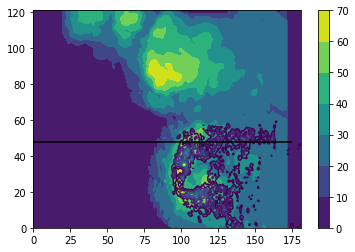

In [110]:
gridcell = 48

plt.contour(np.sum(all_counts,axis=2).T,20)
plt.contourf(r[20])
plt.hlines(gridcell,0,175)
plt.colorbar()

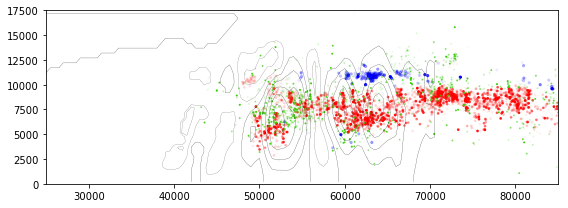

In [111]:
plt.figure(figsize=(8,3))

dist = np.abs(nys-gridcell*dataf.dx)
# alpha = 100./dist
# alpha[alpha>1] = 1
# alpha[alpha<0.05] = 0
alpha = np.exp(-dist/400.)


plt.contour(rx[:,gridcell,:],rz[:,gridcell,:],w[:,gridcell,:],colors='k',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nzs[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nzs[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nzs[unas],color=c,edgecolors=c,s=1)

plt.xlim(50*dataf.dx,170*dataf.dx)
plt.ylim(0,17500)
plt.tight_layout()

#### Other testing

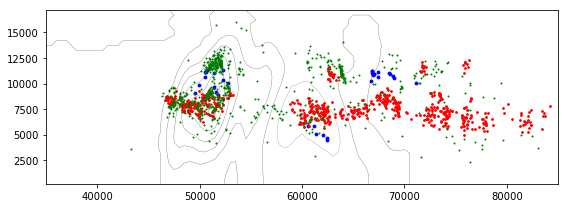

In [57]:
plt.figure(figsize=(8,3))

# gridcell = 60
depth    =  5

plt.contour(rx[:,gridcell,:],rz[:,gridcell,:],w[:,gridcell,:],colors='k',linewidths=0.2)

c = 'b'
selection = (negs) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=8)
c = 'r'
selection = (poss) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=3)
c = 'g'
selection = (unas) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=1)

plt.xlim(70*dataf.dx,170*dataf.dx)
plt.tight_layout()

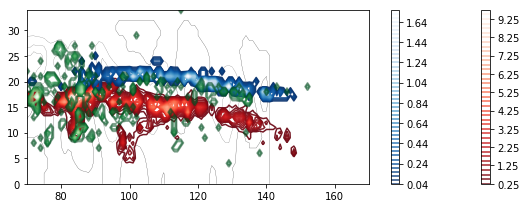

In [14]:
plt.figure(figsize=(8,3))

plt.contour(w[:,gridcell,:],colors='k',linewidths=0.2)

# plt.contour(np.ma.sum(all_counts[:,gridcell-depth:gridcell+depth],axis=1).T,colors='k',linewidths=0.1)
plt.contour(np.sum(p_counts[:,gridcell-depth:gridcell+depth],axis=1).T/depth,40,cmap='Reds_r',alpha=0.9)
plt.colorbar()
plt.contour(np.sum(n_counts[:,gridcell-depth:gridcell+depth],axis=1).T/depth,50,cmap='Blues_r',alpha=0.9)
plt.colorbar()
plt.contour(np.sum(all_counts[:,gridcell-depth:gridcell+depth],axis=1).T-
            np.sum(p_counts[:,gridcell-depth:gridcell+depth],axis=1).T-
            np.sum(n_counts[:,gridcell-depth:gridcell+depth],axis=1).T,30,cmap='Greens_r', alpha=0.5)

plt.xlim(70,170)
plt.tight_layout()

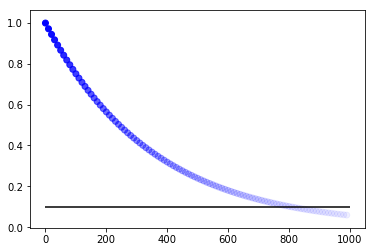

In [102]:
dist = np.arange(0.1,1000,10)
# alpha = 100./(dist)
alpha = np.exp(-dist/350.)
# alpha[alpha>1] = 1

c = np.asarray([(0,0,1,a) for a in alpha])
plt.scatter(dist,alpha,color=c,edgecolors=c)
plt.hlines(0.1,0,1000)